# Predicting Wet / Dry Days over Atlanta, Georgia using  K-Nearest Neighbors

This notebook demonstrates how the k-nearest neighbors classifier can be used to predict wet/dry (rain/no rain) days. The model was trained on data for solar irradiance, surface temperature, tropopause pressure, water vapor, cloud fraction, cloud top pressure, and cloud top temperature in order to predict rainfall. 

The data were downloaded for the period 2015 to 2020 from the Goddard Earth Sciences Data and Information Services Center (https://disc.gsfc.nasa.gov/).

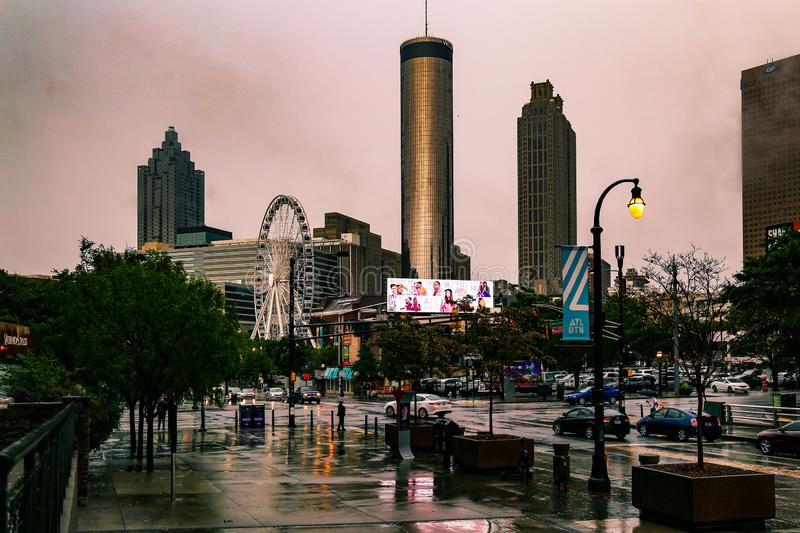

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay

mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 14
warnings.filterwarnings('ignore')

In [2]:
# Read data files for rainfall, cloud fraction, cloud top pressure, cloud top temperature, solar irradiance, surface temperature,
# tropopause pressure, and water vapor 

rain = pd.read_csv(r'C:\Users\opio\Desktop\Data Science\python_projects\ML\classification\rainfall_classification_data\precipitation.csv')
cld_f = pd.read_csv(r'C:\Users\opio\Desktop\Data Science\python_projects\ML\classification\rainfall_classification_data\cloud_fraction.csv')
cld_pr = pd.read_csv(r'C:\Users\opio\Desktop\Data Science\python_projects\ML\classification\rainfall_classification_data\cloud_top_press.csv')
cld_t = pd.read_csv(r'C:\Users\opio\Desktop\Data Science\python_projects\ML\classification\rainfall_classification_data\cloud_top_temp.csv')
irr = pd.read_csv(r'C:\Users\opio\Desktop\Data Science\python_projects\ML\classification\rainfall_classification_data\irradiance.csv')
s_temp = pd.read_csv(r'C:\Users\opio\Desktop\Data Science\python_projects\ML\classification\rainfall_classification_data\surface_temperature.csv')
t_press = pd.read_csv(r'C:\Users\opio\Desktop\Data Science\python_projects\ML\classification\rainfall_classification_data\tropopause_pressure.csv')
water_v = pd.read_csv(r'C:\Users\opio\Desktop\Data Science\python_projects\ML\classification\rainfall_classification_data\water_vapor.csv')

print(rain.head(1))
print('---'*10)
print(irr.head(1))
print('---'*10)
print(s_temp.head(1))
print('---'*10)
print(t_press.head(1))
print('---'*10)
print(water_v.head(1))
print('---'*10)
print(cld_f.head(1))
print('---'*10)
print(cld_pr.head(1))
print('---'*10)
print(cld_t.head(1))
print('---'*10)

         time  rainfall
0  2015-01-01  0.284216
------------------------------
         time    irradiance
0  2015-01-01 -1.270000e+30
------------------------------
         time  surface_temperature
0  2015-01-01              288.375
------------------------------
         time  trop_pressure
0  2015-01-01        151.875
------------------------------
         time  water_vapor
0  2015-01-01        1.502
------------------------------
         time  cloud_fraction
0  2015-01-01        0.246094
------------------------------
         time  cld_top_press
0  2015-01-01      647.80001
------------------------------
         time  cld_top_temp
0  2015-01-01    266.909994
------------------------------


## Data Cleaning and Preparation

In [3]:
# Calculate the percentage of missing data

#For rain, the cell with missing data is assigned the values -9999.9
m_rain = rain[rain['rainfall'] == -9999.9]
percent_missing_rain = (m_rain.shape[0]/rain.shape[0])*100
print('Percentage of missing data for rainfall is', round(percent_missing_rain),'%')

#For solar irradiance, the cell with missing data is assigned the value -1.270000e+30
m_irr = irr[irr['irradiance'] == -1.270000e+30]
percent_missing_irr = (m_irr.shape[0]/irr.shape[0])*100
print('Percentage of missing data for solar irradiance is', round(percent_missing_irr),'%')

#For surface temperature, the cell with missing data is assigned the value -9999
m_s_temp = s_temp[s_temp['surface_temperature'] == -9999]
percent_missing_s_temp = (m_s_temp.shape[0]/s_temp.shape[0])*100
print('Percentage of missing data for surface temperature is', round(percent_missing_s_temp),'%')

#For tropopause pressure, the cell with missing data is assigned the value -9999
m_t_press = t_press[t_press['trop_pressure'] == -9999]
percent_missing_t_press = (m_t_press.shape[0]/t_press.shape[0])*100
print('Percentage of missing data for tropopause pressure is', round(percent_missing_t_press),'%')

#For water vapor, the cell with missing data is assigned the value -9999
m_water_v = water_v[water_v['water_vapor'] == -9999]
percent_missing_water_v = (m_water_v.shape[0]/water_v.shape[0])*100
print('Percentage of missing data for water vapor is', round(percent_missing_water_v),'%')

#For cloud fraction, the cell with missing data is assigned the value -9999
m_cld_f = cld_f[cld_f['cloud_fraction'] == -9999]
percent_missing_cld_f = (m_cld_f.shape[0]/cld_f.shape[0])*100
print('Percentage of missing data for cloud fraction is', round(percent_missing_cld_f),'%')

#For cloud top pressure, the cell with missing data is assigned the value -9999
m_cld_pr = cld_pr[cld_pr['cld_top_press'] == -9999]
percent_missing_cld_pr = (m_cld_pr.shape[0]/cld_pr.shape[0])*100
print('Percentage of missing data for cloud top pressure is', round(percent_missing_cld_pr),'%')

#For cloud top temperature, the cell with missing data is assigned the value -9999
m_cld_t = cld_t[cld_t['cld_top_temp'] == -9999]
percent_missing_cld_t = (m_cld_t.shape[0]/cld_t.shape[0])*100
print('Percentage of missing data for cloud top temperature is', round(percent_missing_cld_t),'%')

Percentage of missing data for rainfall is 0 %
Percentage of missing data for solar irradiance is 34 %
Percentage of missing data for surface temperature is 20 %
Percentage of missing data for tropopause pressure is 14 %
Percentage of missing data for water vapor is 13 %
Percentage of missing data for cloud fraction is 13 %
Percentage of missing data for cloud top pressure is 6 %
Percentage of missing data for cloud top temperature is 6 %


In [4]:
# We cannot fill in the missing data with mean values, because the large fill values used will distort the final result,
# therefore, we are select only the portions of the data frame without missing data.
# The alternative method would have been to drop the rows with missing data.

irr1 = irr[irr['irradiance'] != -1.270000e+30]
s_temp1 = s_temp[s_temp['surface_temperature'] != -9999]
t_press1 = t_press[t_press['trop_pressure'] != -9999]
water_v1 = water_v[water_v['water_vapor'] != -9999]
cld_f1 = cld_f[cld_f['cloud_fraction'] != -9999]
cld_pr1 = cld_pr[cld_pr['cld_top_press'] != -9999]
cld_t1 = cld_t[cld_t['cld_top_temp'] != -9999]

In [5]:
# Create a joint data frame that combines all the data based on the time(date) column.
# Our interest is to retain as much data as posssible, and all the data must have been recorded on the same day.

df1 = rain.merge(irr1, how='inner', on='time')
df2 = df1.merge(s_temp1, how='inner', on='time')
df3 = df2.merge(t_press1, how='inner', on='time')
df4 = df3.merge(water_v1, how='inner', on='time')
df5 = df4.merge(cld_f1, how='inner', on='time')
df6 = df5.merge(cld_pr1, how='inner', on='time')
df = df6.merge(cld_t1, how='inner', on='time')

print(df.head())
print('====='*15)
print(df.info())

         time  rainfall  irradiance  surface_temperature  trop_pressure  \
0  2015-01-07  0.000050  299.969574             284.2500        155.875   
1  2015-01-09  0.035804  343.804047             281.6250        200.000   
2  2015-01-19  0.001812  476.575897             293.1875        207.875   
3  2015-01-20  0.090530  468.315765             295.3125        219.750   
4  2015-01-28  0.000000  510.334961             288.5000        213.500   

   water_vapor  cloud_fraction  cld_top_press  cld_top_temp  
0        1.677        0.843750     539.400008    259.579994  
1        1.434        0.609375     541.500008    257.129994  
2        1.037        0.076172     450.000007    245.459995  
3        0.979        0.166992     376.600006    235.739995  
4        0.942        0.000359     990.000015    282.389994  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 874 entries, 0 to 873
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------            

## Exploratory Data Analysis

In [6]:
df.head()

,time,rainfall,irradiance,surface_temperature,trop_pressure,water_vapor,cloud_fraction,cld_top_press,cld_top_temp
0,2015-01-07,0.000050,299.969574,284.2500,155.875,1.677,0.843750,539.400008,259.579994
1,2015-01-09,0.035804,343.804047,281.6250,200.000,1.434,0.609375,541.500008,257.129994
2,2015-01-19,0.001812,476.575897,293.1875,207.875,1.037,0.076172,450.000007,245.459995
3,2015-01-20,0.090530,468.315765,295.3125,219.750,0.979,0.166992,376.600006,235.739995
4,2015-01-28,0.000000,510.334961,288.5000,213.500,0.942,0.000359,990.000015,282.389994


In [7]:
# Get descriptive statistics

df.describe()

,rainfall,irradiance,surface_temperature,trop_pressure,water_vapor,cloud_fraction,cld_top_press,cld_top_temp
count,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000,874.000000
mean,2.902429,589.241172,300.103189,144.340318,2.698837,0.381588,657.438797,267.995143
std,8.065342,173.905427,7.751348,37.860876,1.462484,0.256935,267.525298,25.835890
min,0.000000,73.198097,270.750000,83.875000,0.294000,0.000000,159.300002,210.189995
25%,0.001457,469.649856,295.578125,119.750000,1.416250,0.180664,392.000006,244.447495
50%,0.116719,631.256439,302.093750,133.062500,2.430500,0.342773,737.650011,277.474994
75%,1.719318,729.024094,305.750000,164.000000,3.780500,0.569336,908.575014,290.752494
max,121.911751,838.557800,314.562500,330.750000,6.810000,1.000000,1003.700010,303.229993


Text(0.5, 0, 'Cloud Top Pressure (hPa)')

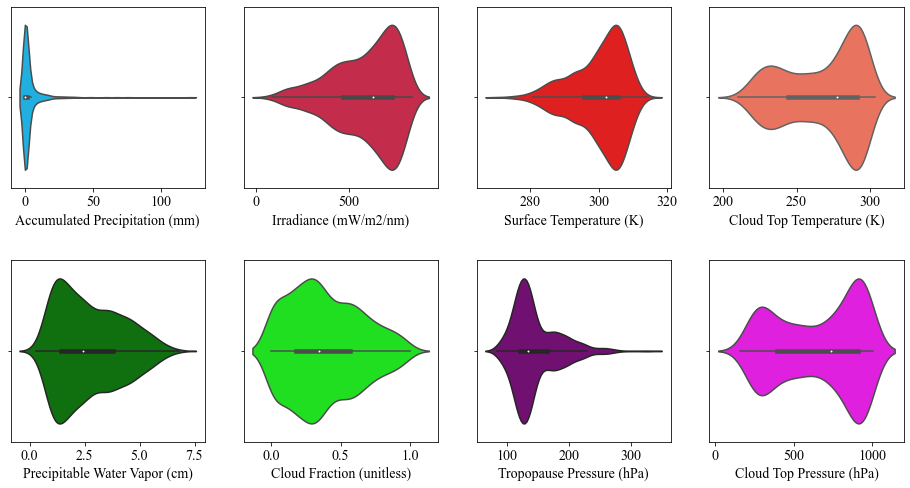

In [8]:
# Do violin plots

fig, ax = plt.subplots(figsize=(16,8))
plt.gcf().subplots_adjust(hspace=0.4)

plt.subplot(2,4,1)
sns.violinplot(df['rainfall'], color='deepskyblue')
plt.xlabel('Accumulated Precipitation (mm)')

plt.subplot(2,4,2)
sns.violinplot(df['irradiance'], color='crimson')
plt.xlabel('Irradiance (mW/m2/nm)')

plt.subplot(2,4,3)
sns.violinplot(df['surface_temperature'], color='red')
plt.xlabel('Surface Temperature (K)')

plt.subplot(2,4,4)
sns.violinplot(df['cld_top_temp'], color='tomato')
plt.xlabel('Cloud Top Temperature (K)')

plt.subplot(2,4,5)
sns.violinplot(df['water_vapor'], color='green')
plt.xlabel('Precipitable Water Vapor (cm)')

plt.subplot(2,4,6)
sns.violinplot(df['cloud_fraction'], color='lime')
plt.xlabel('Cloud Fraction (unitless)')

plt.subplot(2,4,7)
sns.violinplot(df['trop_pressure'], color='purple')
plt.xlabel('Tropopause Pressure (hPa)')

plt.subplot(2,4,8)
sns.violinplot(df['cld_top_press'], color='magenta')
plt.xlabel('Cloud Top Pressure (hPa)')

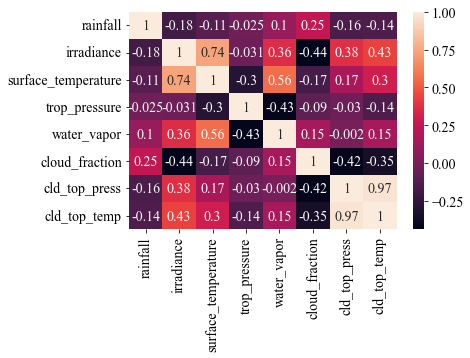

In [9]:
# Check for correlations

corr = df.corr('pearson')
sns.heatmap(corr, annot=True)
plt.show()

## Machine Learning Classfication

<AxesSubplot:xlabel='rainfall', ylabel='count'>

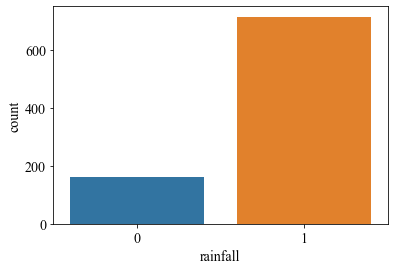

In [10]:
# Make rainfall column to be categorical, that is, days with rainfall = 1, and days with no rainfall = 0 

df['rainfall'] = np.where(df['rainfall'] > 0, 1, 0)

sns.countplot(df['rainfall'])

In [11]:
# Select variables

X = df.drop(['time', 'rainfall'], axis=1)
y = df['rainfall']

In [12]:
# Do feature selection based on K highest scores

selector = SelectKBest(chi2, k=7)
x = selector.fit_transform(X, y)

print('Former shape', X.shape)
print('Current shape', x.shape)
print('---'*20)

print('Selected Features are:')
X.columns[selector.get_support(indices=True)]

Former shape (874, 7)
Current shape (874, 7)
------------------------------------------------------------
Selected Features are:


Index(['irradiance', 'surface_temperature', 'trop_pressure', 'water_vapor',
       'cloud_fraction', 'cld_top_press', 'cld_top_temp'],
      dtype='object')

In [13]:
#X_new = X.drop(['surface_temperature', 'trop_pressure'], axis=1)
# Iran this script and I realized that the best accuracy is achieved when all the 7 parameters are used

X_new = X
X_new.columns

Index(['irradiance', 'surface_temperature', 'trop_pressure', 'water_vapor',
       'cloud_fraction', 'cld_top_press', 'cld_top_temp'],
      dtype='object')

In [14]:
# Scale the data
scaler = preprocessing.MinMaxScaler()

x_new = pd.DataFrame(scaler.fit_transform(X_new, y), columns=X_new.columns)

x_new.head()

,irradiance,surface_temperature,trop_pressure,water_vapor,cloud_fraction,cld_top_press,cld_top_temp
0,0.296294,0.308131,0.291646,0.212247,0.843750,0.450142,0.530847
1,0.353567,0.248217,0.470380,0.174954,0.609375,0.452629,0.504514
2,0.527043,0.512126,0.502278,0.114027,0.076172,0.344268,0.379084
3,0.516251,0.560628,0.550380,0.105126,0.166992,0.257342,0.274613
4,0.571152,0.405136,0.525063,0.099448,0.000359,0.983775,0.776010


In [15]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.3)

In [16]:
# Classify with K neighbors classifier

classifier_KNN = KNeighborsClassifier(n_neighbors=5)
KNN = classifier_KNN.fit(X_train, y_train)
KNN_prediction = KNN.predict(X_test)

## Evaluation

In [17]:
# Calculate model accuracy

print('Accuracy is', accuracy_score(y_test, KNN_prediction).round(3)*100,'%')

Accuracy is 83.3 %


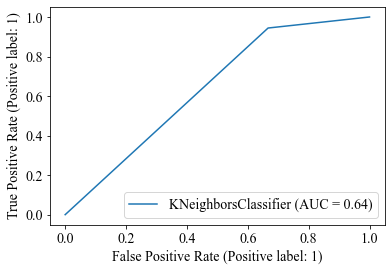

In [18]:
#Plot AUC curve

RocCurveDisplay.from_predictions(y_test, KNN_prediction, name='KNeighborsClassifier')
plt.show()

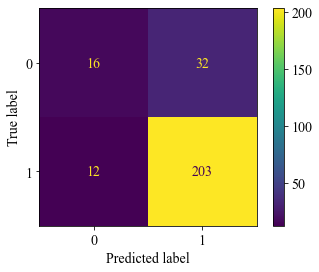

In [19]:
# Plot confusion matrix

cm = confusion_matrix(y_test, KNN_prediction)
cm_d = ConfusionMatrixDisplay(cm)
cm_d.plot()
plt.show()

In [21]:
print('Sensitivity or True Positive Rate = TP/(TP+FN) =', 203/(203+12))
print('Specificity or True Negative Rate = TN/(TN+FP) =', 16/(16+32))

Sensitivity or True Positive Rate = TP/(TP+FN) = 0.9441860465116279
Specificity or True Negative Rate = TN/(TN+FP) = 0.3333333333333333


## Summary

### 1. A K-Nearest Neighbor (KNN) classifier was trained to predict wet / dry (rain / no rain) days over Atlanta, Georgia using data of solar irradiance, surface temperature, cloud fraction, cloud top pressure, cloud top temperature, tropopause pressure, and water vapor.
### 2. The KNN model achived an accuracy of 83.3% when all 7 features were used. 
### 3. The trained model had a 0.94 probability of correctly predicting a wet (rainy) day.